In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import statistics
import math

In [3]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((406, 195))
for i in range(406):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_albedo[i, :] = surf_alb

#Computing tau
mu = np.cos(africa.variables["VZA"][0,:,224])
mu_0 = np.cos(africa.variables["SZA"][0,:,224])
mu_matrix = np.cos(np.tile(mu[:, np.newaxis], 195))
mu_0_matrix = np.cos(np.tile(mu_0[:, np.newaxis], 195))
reflectance_matrix = africa.variables['Reflectance'][0, :, 224, 276:471].data

tau = -np.log(reflectance_matrix/surf_albedo)/ (np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))


In [43]:
ind_tensor = torch.tensor(ind, dtype=torch.float32).reshape(-1, 1)
tau_tensor = torch.tensor(tau.transpose(), dtype=torch.float32).unsqueeze(1) #195x1x406
target_tau = torch.tensor(tau.mean(axis = 0), dtype=torch.float32).reshape(-1,1)
tau_tensor.shape, target_tau.shape
from torch.utils.data import DataLoader, TensorDataset, random_split

# Split into training and test sets (80% train, 20% test)
train_size = int(0.8 * tau_tensor.shape[0])
test_size = tau_tensor.shape[0] - train_size

train_dataset, test_dataset = random_split(TensorDataset(tau_tensor, target_tau), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [45]:
class SimpleSpectralCNN(nn.Module):
    def __init__(self):
        super(SimpleSpectralCNN, self).__init__()
        # First convolutional layer: in_channels=1, out_channels=16, kernel_size=3
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer: increasing the feature channels
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # A pooling layer to reduce dimensionality and capture invariance
        self.pool = nn.MaxPool1d(kernel_size=2)
        # Fully connected layer to map the extracted features to your output
        # We need to compute the size after the convolutions and pooling.
        # For an input length of 195, after one pooling (kernel 2) the length becomes ~97 or 98.
        # For simplicity, let's assume it reduces to 97, and with 32 channels: 32*97.
        self.fc = nn.Linear(32 * 203, 1)  # For a regression output

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)           
        x = x.view(x.size(0), -1)  
        x = self.fc(x)             
        return x

# Instantiate the model
model = SimpleSpectralCNN()

In [46]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
num_epochs = 10000
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_preds = model(X_batch)
            test_loss = criterion(test_preds, y_batch)
            epoch_test_loss += test_loss.item()

    test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 5000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")


Epoch [5000/10000], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [10000/10000], Train Loss: 0.000000, Test Loss: 0.000000


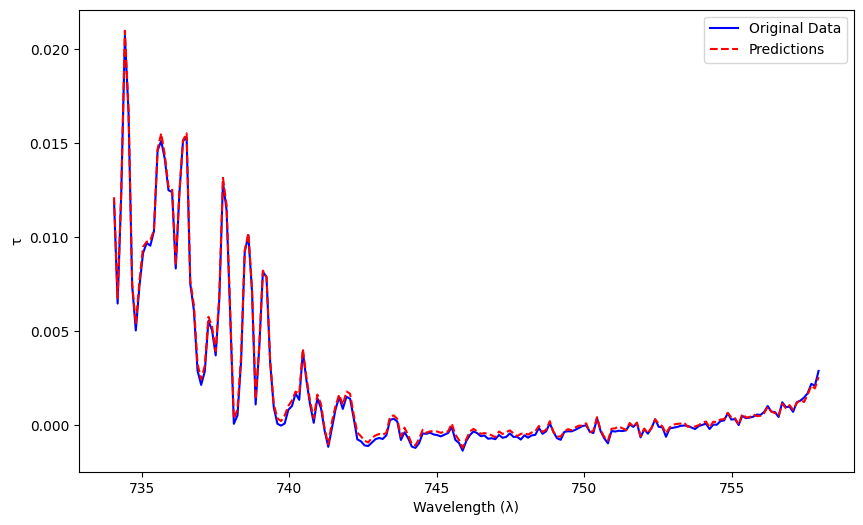

In [58]:
model.eval()
with torch.no_grad():
    predictions = model(tau_tensor).squeeze(1).numpy()  # (195,)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], target_tau.numpy().flatten(), color='blue', label='Original Data')
plt.plot(wl[ind], predictions, color='red', label='Predictions', linestyle='dashed')
plt.xlabel('Wavelength (λ)')
plt.ylabel('τ')
plt.legend()
plt.savefig("CNN-africa")
plt.show()

In [59]:
from sklearn.metrics import r2_score
with torch.no_grad():
    y_pred = model(X_test)
    r2 = r2_score(y_test.numpy(), y_pred.numpy())
    print(f"\nFinal R² Score: {r2:.4f}")


Final R² Score: 0.9987
